In [278]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import gcf
import numpy as np 
from einops import rearrange
from sklearn import cluster
from sklearn import metrics
from collections import Counter
%load_ext autoreload
%autoreload 2
from sklearn.decomposition import non_negative_factorization
import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition._nmf import NMF
import math
import seaborn as sns
from matplotlib.patches import Rectangle

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique 
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3,get_indices_2ormore#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder

#load data
def cv_nmf_missing(data, n_components,alpha=0.01, l1_ratio = 1.,p_holdout = .3):
    
    missings = np.asarray(np.where(np.isnan(data))).transpose()
    presents = np.asarray(np.where(~np.isnan(data))).transpose()

    M = np.where(np.random.rand(presents.shape[0]) > p_holdout)[0]
    N = np.where(np.random.rand(presents.shape[0]) < p_holdout)[0]

    nmf = NMF(n_components=n_components, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)

    data_tr = data.copy()
    for i in range(len(M)):
        data_tr[presents[M[i],0] ,presents[M[i],1]]  =np.nan

    data_te = data.copy()
    for i in range(len(N)):
        data_te[presents[N[i],0] ,presents[N[i],1]]  =np.nan

    nmf.fit(data_tr)

    tr_nmf_embedding = nmf.transform(data_tr)
    te_nmf_embedding = nmf.transform(data_te)

    tr_nmf_recon = nmf.inverse_transform(tr_nmf_embedding)
    te_nmf_recon = nmf.inverse_transform(te_nmf_embedding)
    tr_err = np.nanmean((data_tr - tr_nmf_recon)**2)
    te_err= np.nanmean((data_te - te_nmf_recon)**2)
    
    return(tr_err, te_err)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        #cmap(np.linspace(maxval, minval, n)))
        cmap(np.linspace(minval,maxval , n)))
    return new_cmap

#arr = np.linspace(0, 50, 100).reshape((10, 10))
#fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('Greys')
new_cmap = truncate_colormap(cmap, 0.1,1.)

def fix_pdcsv(csv):
    
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

def fill_df_na(data, indices):
    
    for i in range(indices.shape[0]):
        data.iloc[indices[i,0],indices[i,1]] = np.nan
        
    return(data)

def get_colors(structures, palettes, alpha):
    
    strs_unique = np.unique(structures)
    nstr = len(strs_unique)
    cs = sns.color_palette("Spectral", nstr)
    
    #print(np.asarray(cs).shape, np.expand_dims(np.ones(12),1).shape)
    cs_alphas = np.hstack([np.asarray(cs), alpha*np.expand_dims(np.ones(12),1)])
    color_str = {}
    for i in range(nstr):
        #print(i)
        color_str[strs_unique[i]] = cs_alphas[i]
    #print(color_str['CB'])
    #print(color_str)
    output = np.zeros((len(structures),4), dtype  =float)
    for i in range(len(structures)):
        #print(np.asarray(color_str[structures[i]]))
        output[i] = np.asarray(color_str[structures[i]])
        
    return(output,color_str)


TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')

#wt_conn = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_leafsurf_leafsmth_leafleaf_meandata_0428_log6.csv',  header=[0,1])
wt_conn = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_leafsurf_leafsmth_leafleaf_C57BL6J0428_log6.csv',  header=[0,1])
wt_conn = fix_pdcsv(wt_conn)
#dists = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/distances.csv',  header=[0,1])
#dists = fix_pdcsv(dists)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
annotation/ccf_2017


In [2]:
dists = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/distances_leaf_leaf.npy')

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()

ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#get ontological order structures and leaf major regions
#oos_ic_majors = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/oos_ic_majors_v3.npy')
ool_ic_majors = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/ool_ic_majors_names_v3_0610.npy')
ool_i_majors = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/ool_i_majors_names_v3_0610.npy')
ool_ic_majors = np.asarray([ia_map[ool_ic_majors[i ]] for i in range(len(ool_ic_majors))])
ool_i_majors = np.asarray([ia_map[ool_i_majors[i ]] for i in range(len(ool_i_majors))])
#ccol,ccol_dict = get_colors(np.asarray(ool_ic_majors), sns.color_palette("Spectral", 12), 1.)
#crow,crow_dict = get_colors(np.asarray(ool_i_majors), sns.color_palette("Spectral", 12), 1.)
reo = np.asarray([4,7,2,1,10,9,11,3,5,8,6,0])
low_values = np.asarray(np.where(dists < 15)).transpose()

In [16]:
data = np.asarray(fill_df_na(wt_conn, low_values))
rss= np.nansum(data, axis = 1)
ids = np.where(rss > 0.)[0]
data= data[ids]

wt_conn.columns.names = np.asarray(['Hemisphere', 'Structure'])
hemi_labels = wt_conn.columns.get_level_values("Hemisphere")
hemi_pal = sns.color_palette("cubehelix", n_colors = hemi_labels.unique().size)
hemi_lut = dict(zip(map(str, hemi_labels.unique()), hemi_pal))
hemi_colors = pd.Series(hemi_labels, index=wt_conn.columns).map(hemi_lut)

targ_str_labels = ool_ic_majors#wt_conn.columns.get_level_values("Structure")
targ_str_pal = sns.color_palette("tab20", n_colors = np.unique(targ_str_labels).size)
targ_str_lut = dict(zip(map(str, np.unique(targ_str_labels)), targ_str_pal))
targ_str_colors = pd.Series(targ_str_labels, index=wt_conn.columns).map(targ_str_lut)

source_str_labels = ool_i_majors
source_str_pal = sns.color_palette("tab20", n_colors = np.unique(source_str_labels).size)
source_str_lut = dict(zip(map(str, np.unique(source_str_labels)), source_str_pal))
source_str_colors = pd.Series(source_str_labels, index=wt_conn.index).map(source_str_lut)

arr_targ = np.zeros((1123,2), dtype = object)
arr_targ[:,0] = hemi_colors
arr_targ[:,1] = targ_str_colors
combined_colors_targ = pd.DataFrame(arr_targ, index = wt_conn.columns)

arr_source = np.zeros((564,1), dtype = object)
arr_source[:,0] = source_str_colors
combined_colors_source = pd.DataFrame(arr_source, index = wt_conn.index)


In [17]:
dists = pd.DataFrame(dists, index= wt_conn.index, columns = wt_conn.columns)
combined_colors_targ.columns = np.asarray(['Hemisphere','Major Structure'])
combined_colors_source.columns = np.asarray(['Major Structure'])

strs_unique = np.unique(ool_ic_majors)
nstr = len(strs_unique)
cs = sns.color_palette("tab20", nstr)

#print(np.asarray(cs).shape, np.expand_dims(np.ones(12),1).shape)
#cs_alphas = np.hstack([np.asarray(cs), alpha*np.expand_dims(np.ones(12),1)])
color_str = {}
for i in range(nstr):
    #print(i)
    color_str[strs_unique[i]] = cs[i]
  
cs_hemi = sns.color_palette("cubehelix", 2)

color_hemi = {}
hemis = np.asarray(['Ipsi','Contra'])
for i in range(2):
    #print(i)
    color_hemi[hemis[i]] = cs_hemi[i]

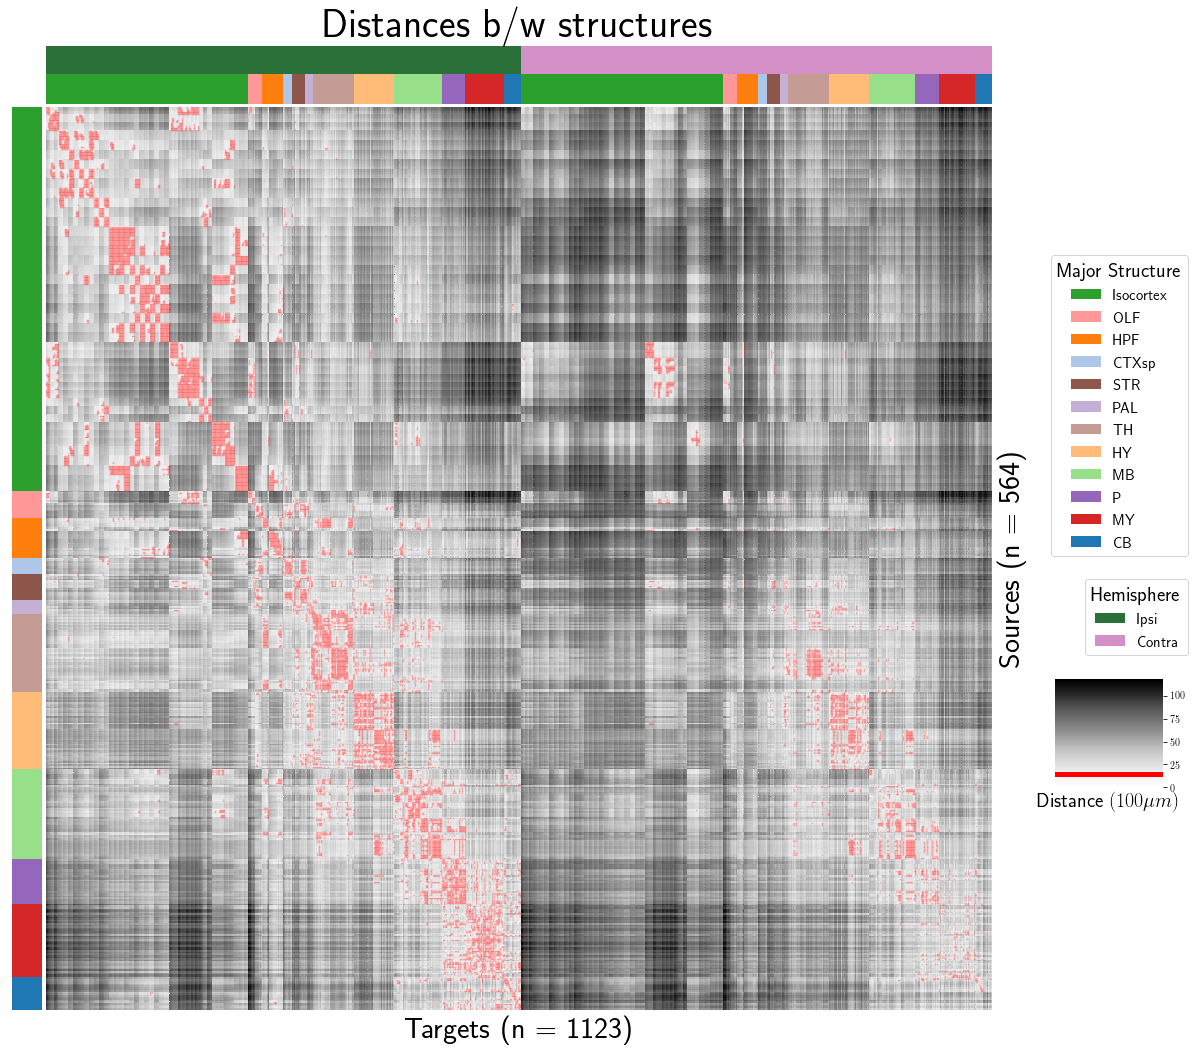

In [18]:
g = sns.clustermap(dists,
                   col_cluster = False,
                   row_cluster = False, 
                   figsize = (15,15), 
                   cmap = 'Greys',
                   col_colors = combined_colors_targ, 
                   row_colors = combined_colors_source, 
                   dendrogram_ratio=0.001)
g.ax_col_colors.set_yticks([])
g.ax_row_colors.set_xticks([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xlabel('Targets (n = 1123)', fontsize = 30)
g.ax_heatmap.set_ylabel('Sources (n = 564)', fontsize = 30)
ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=color_str[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.11, .8), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

ax2 = gcf().add_axes((0.55,.5,0.,0.))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
for label in hemis:
    ax2.bar(0, 0, color=color_hemi[label], label=label, linewidth=0.)
l4 = ax2.legend(title='Hemisphere', ncol=1, bbox_to_anchor=(1.11, .5), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Distance ' +  r'$(100 \mu m)$', rotation=0, fontsize = 20)
g.ax_cbar.set_position([.98,0.3,.1,.1])
g.ax_cbar.axhline(15, color = 'red', linewidth = 5)
g.ax_col_colors.set_title('Distances b/w structures', fontsize = 40)
for i in range(low_values.shape[0]):
    #print(i)
    g.ax_heatmap.add_patch(Rectangle((low_values[i][1],low_values[i][0]), 1, 1, fill=False, edgecolor='red', lw=.15))

#g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/figures/distances_leafs.png', bbox_inches = 'tight',pad_inches = 0)




In [7]:
# train_err = []
# test_err = []
# nrep = 5
# tr_results = np.zeros((nrep,25))
# te_results = np.zeros((nrep,25))
# for n in range(1,10):
#     print(n)
#     for r in range(nrep):
#         #print(r)
#         tr_results[r,n] , te_results[r,n] = cv_nmf_missing(data, n_components = n ,alpha=.001, l1_ratio = 1.,p_holdout = .3)

In [8]:
# splits = np.asarray(['Train','Test'])
# colorsplits = {}
# colorsplits['Train'] = 'red'
# colorsplits['Test']=  'blue'

# fig , ax = plt.subplots(figsize = (15,15))
# sns.boxplot( data = te_results[:,1:], ax=  ax, color= 'blue')
# sns.boxplot( data = tr_results[:,1:], ax=  ax, color= 'red')
# ax.set_xticklabels(list(range(1,25)))
# ax.axvline(14, color='k', dashes=[2,2])
# ax.text(20,np.nanmax(te_results[:,1:]), 'Train',color = 'red', fontsize = 40)
# ax.text(20,.9*np.nanmax(te_results[:,1:]), 'Test',color = 'blue', fontsize = 40)
# ax.set_ylabel(r"$\frac{1}{n'} \sum_{i = 1}^{n'}  \|\hat y_i^c - y_i\|_2^2$", fontsize = 40)
# ax.set_xlabel('# Components c', fontsize = 40)
# # fig.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/KoelleConnectivity/figs/test_train_0603.png', bbox_inches = 'tight',
# #    pad_inches = 0)
# #ax.legend()

In [38]:
train_err = []
test_err = []
nrep = 8
tr_results = np.zeros((nrep,8))
te_results = np.zeros((nrep,8))
for n in range(1,9):
    print(n)
    for r in range(nrep):
        #print(r)
        tr_results[r,n-1] , te_results[r,n-1] = cv_nmf_missing(data, n_components = n*10 ,alpha=.0002, l1_ratio = 1.,p_holdout = .3)

1


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

2


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

3


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

4


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

5


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

6


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

7


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

8


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

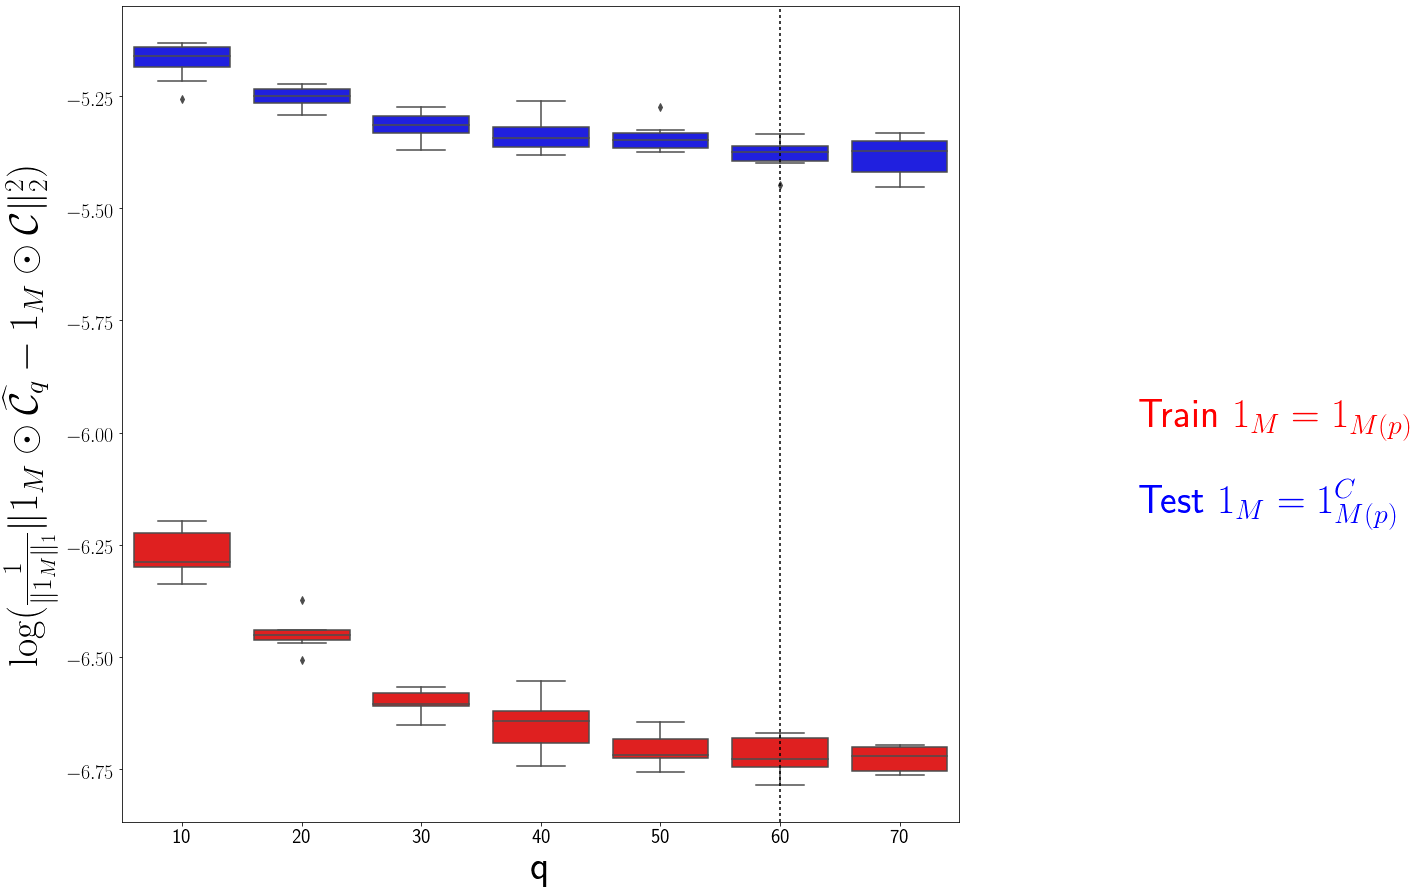

In [152]:
#alpha .0002
splits = np.asarray(['Train','Test'])
colorsplits = {}
colorsplits['Train'] = 'red'
colorsplits['Test']=  'blue'

fig , ax = plt.subplots(figsize = (15,15))
sns.boxplot( data = np.log10(te_results[:,1:]), ax=  ax, color= 'blue')
sns.boxplot( data = np.log10(tr_results[:,1:]), ax=  ax, color= 'red')
#ax.set_xticklabels(list(range(1,11)))
ax.axvline(5, color='k', dashes=[2,2])
ax.text(8,-6, 'Train '+ r"$1_M = 1_{M(p)}$",color = 'red', fontsize = 40)
ax.text(8,-6.2, 'Test '+ r"$1_M = 1_{M(p)}^C$",color = 'blue', fontsize = 40)
ax.set_ylabel(r"$\log(\frac{1}{\|1_{M}\|_1 } \| 1_{M} \odot \widehat {\mathcal C_q} - 1_{M} \odot \mathcal C \|_2^2)$", fontsize = 40)
ax.set_xlabel('q', fontsize = 40)
ax.set_xticklabels(np.asarray(list(range(1,11)))*10, fontsize = 20)
plt.yticks(fontsize = 20)
fig.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/KoelleConnectivity/figs/test_train_0603.png', bbox_inches = 'tight',
   pad_inches = 0)
# #ax.legend()

(array([-6.2, -6. , -5.8, -5.6, -5.4, -5.2, -5. ]),
 <a list of 7 Text yticklabel objects>)

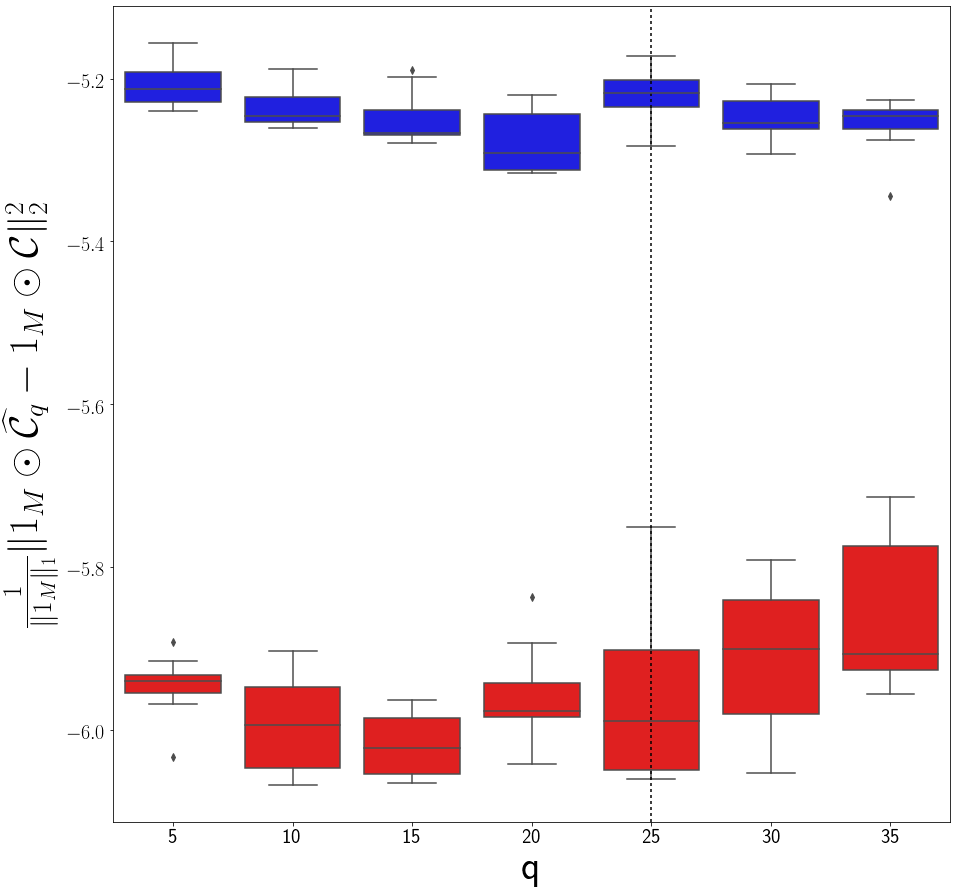

In [37]:
#alpha .0005
splits = np.asarray(['Train','Test'])
colorsplits = {}
colorsplits['Train'] = 'red'
colorsplits['Test']=  'blue'

fig , ax = plt.subplots(figsize = (15,15))
sns.boxplot( data = np.log10(te_results[:,1:]), ax=  ax, color= 'blue')
sns.boxplot( data = np.log10(tr_results[:,1:]), ax=  ax, color= 'red')
#ax.set_xticklabels(list(range(1,11)))
ax.axvline(4, color='k', dashes=[2,2])
#ax.text(9,np.nanmax(te_results[:,1:]), 'Train '+ r"$1_M = 1_{M(p)}$",color = 'red', fontsize = 40)
#ax.text(9,.9*np.nanmax(te_results[:,1:]), 'Test '+ r"$1_M = 1_{M(p)}^C$",color = 'blue', fontsize = 40)
ax.set_ylabel(r"$\frac{1}{\|1_{M}\|_1 } \| 1_{M} \odot \widehat {\mathcal C_q} - 1_{M} \odot \mathcal C \|_2^2$", fontsize = 40)
ax.set_xlabel('q', fontsize = 40)
ax.set_xticklabels(np.asarray(list(range(1,11)))*5, fontsize = 20)
plt.yticks(fontsize = 20)
# fig.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/KoelleConnectivity/figs/test_train_0603.png', bbox_inches = 'tight',
#    pad_inches = 0)
# #ax.legend()

In [33]:
train_err = []
test_err = []
nrep = 8
tr_results = np.zeros((nrep,12))
te_results = np.zeros((nrep,12))
for n in range(1,13):
    print(n)
    for r in range(nrep):
        #print(r)
        tr_results[r,n-1] , te_results[r,n-1] = cv_nmf_missing(data, n_components = n*25 ,alpha=.0001, l1_ratio = 1.,p_holdout = .3)

1


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

2


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

3


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

4


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

5


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

6


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

7


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

8


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

9


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

10


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

11


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

12


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

In [34]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

(array([-8. , -7.5, -7. , -6.5, -6. , -5.5, -5. ]),
 <a list of 7 Text yticklabel objects>)

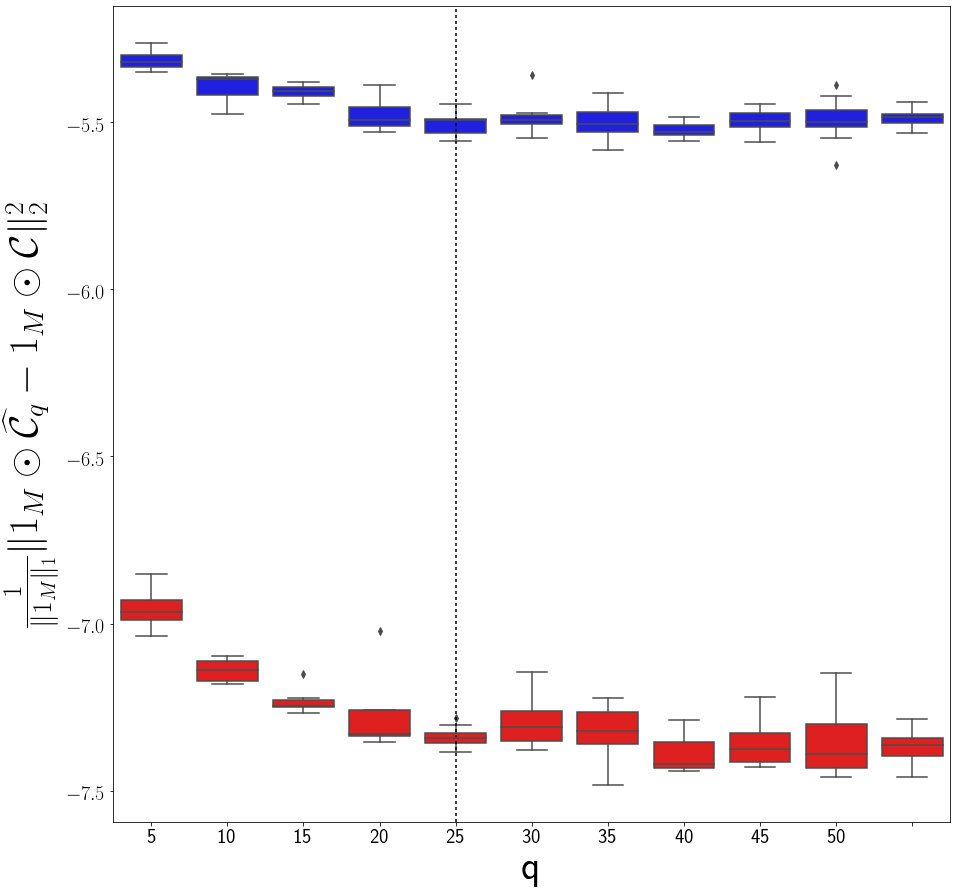

In [35]:
#alpha .0001
splits = np.asarray(['Train','Test'])
colorsplits = {}
colorsplits['Train'] = 'red'
colorsplits['Test']=  'blue'

fig , ax = plt.subplots(figsize = (15,15))
sns.boxplot( data = np.log10(te_results[:,1:]), ax=  ax, color= 'blue')
sns.boxplot( data = np.log10(tr_results[:,1:]), ax=  ax, color= 'red')
#ax.set_xticklabels(list(range(1,11)))
ax.axvline(4, color='k', dashes=[2,2])
#ax.text(9,np.nanmax(te_results[:,1:]), 'Train '+ r"$1_M = 1_{M(p)}$",color = 'red', fontsize = 40)
#ax.text(9,.9*np.nanmax(te_results[:,1:]), 'Test '+ r"$1_M = 1_{M(p)}^C$",color = 'blue', fontsize = 40)
ax.set_ylabel(r"$\frac{1}{\|1_{M}\|_1 } \| 1_{M} \odot \widehat {\mathcal C_q} - 1_{M} \odot \mathcal C \|_2^2$", fontsize = 40)
ax.set_xlabel('q', fontsize = 40)
ax.set_xticklabels(np.asarray(list(range(1,11)))*5, fontsize = 20)
plt.yticks(fontsize = 20)
# fig.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/KoelleConnectivity/figs/test_train_0603.png', bbox_inches = 'tight',
#    pad_inches = 0)
# #ax.legend()

(array([-7.25, -7.  , -6.75, -6.5 , -6.25, -6.  , -5.75, -5.5 , -5.25,
        -5.  , -4.75]), <a list of 11 Text yticklabel objects>)

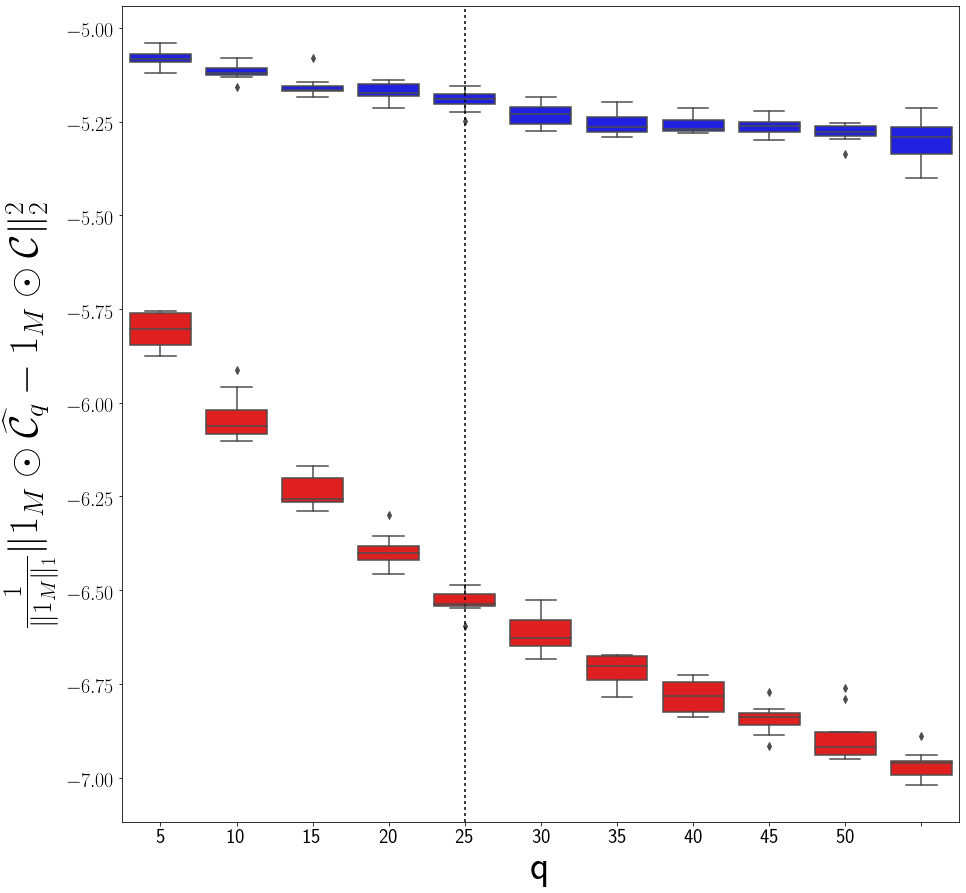

In [27]:
splits = np.asarray(['Train','Test'])
colorsplits = {}
colorsplits['Train'] = 'red'
colorsplits['Test']=  'blue'

fig , ax = plt.subplots(figsize = (15,15))
sns.boxplot( data = np.log10(te_results[:,1:]), ax=  ax, color= 'blue')
sns.boxplot( data = np.log10(tr_results[:,1:]), ax=  ax, color= 'red')
#ax.set_xticklabels(list(range(1,11)))
ax.axvline(4, color='k', dashes=[2,2])
#ax.text(9,np.nanmax(te_results[:,1:]), 'Train '+ r"$1_M = 1_{M(p)}$",color = 'red', fontsize = 40)
#ax.text(9,.9*np.nanmax(te_results[:,1:]), 'Test '+ r"$1_M = 1_{M(p)}^C$",color = 'blue', fontsize = 40)
ax.set_ylabel(r"$\frac{1}{\|1_{M}\|_1 } \| 1_{M} \odot \widehat {\mathcal C_q} - 1_{M} \odot \mathcal C \|_2^2$", fontsize = 40)
ax.set_xlabel('q', fontsize = 40)
ax.set_xticklabels(np.asarray(list(range(1,11)))*5, fontsize = 20)
plt.yticks(fontsize = 20)
# fig.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/KoelleConnectivity/figs/test_train_0603.png', bbox_inches = 'tight',
#    pad_inches = 0)
# #ax.legend()

In [145]:
    #def cv_nmf_missing(data, n_components,alpha=0.01, l1_ratio = 1.,p_holdout = .3):
    n_components = 5
    alpha=.0001
    l1_ratio = 1.
    p_holdout = .3
    missings = np.asarray(np.where(np.isnan(data))).transpose()
    presents = np.asarray(np.where(~np.isnan(data))).transpose()

    M = np.where(np.random.rand(presents.shape[0]) > p_holdout)[0]
    N = np.where(np.random.rand(presents.shape[0]) < p_holdout)[0]

    nmf = NMF(n_components=n_components, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)

    data_tr = data.copy()
    for i in range(len(M)):
        data_tr[presents[M[i],0] ,presents[M[i],1]]  =np.nan

    data_te = data.copy()
    for i in range(len(N)):
        data_te[presents[N[i],0] ,presents[N[i],1]]  =np.nan

    nmf.fit(data_tr)

    tr_nmf_embedding = nmf.transform(data_tr)
    te_nmf_embedding = nmf.transform(data_te)

    tr_nmf_recon = nmf.inverse_transform(tr_nmf_embedding)
    te_nmf_recon = nmf.inverse_transform(te_nmf_embedding)
    tr_err = np.nanmean((data_tr - tr_nmf_recon)**2)
    te_err= np.nanmean((data_te - te_nmf_recon)**2)
    
    #return(tr_err, te_err)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [146]:
tr_err, te_err

(3.1675801172289625e-06, 8.624475026482743e-06)

In [151]:
    nmf = NMF(n_components = 25, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)
    nmf.fit(data_tr)

    tr_nmf_embedding = nmf.transform(data_tr)
    te_nmf_embedding = nmf.transform(data_te)

    tr_nmf_recon = nmf.inverse_transform(tr_nmf_embedding)
    te_nmf_recon = nmf.inverse_transform(te_nmf_embedding)
    tr_err = np.nanmean((data_tr - tr_nmf_recon)**2)
    te_err= np.nanmean((data_te - te_nmf_recon)**2)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [152]:
tr_err, te_err

(3.1812367941640674e-07, 6.1104144752425895e-06)

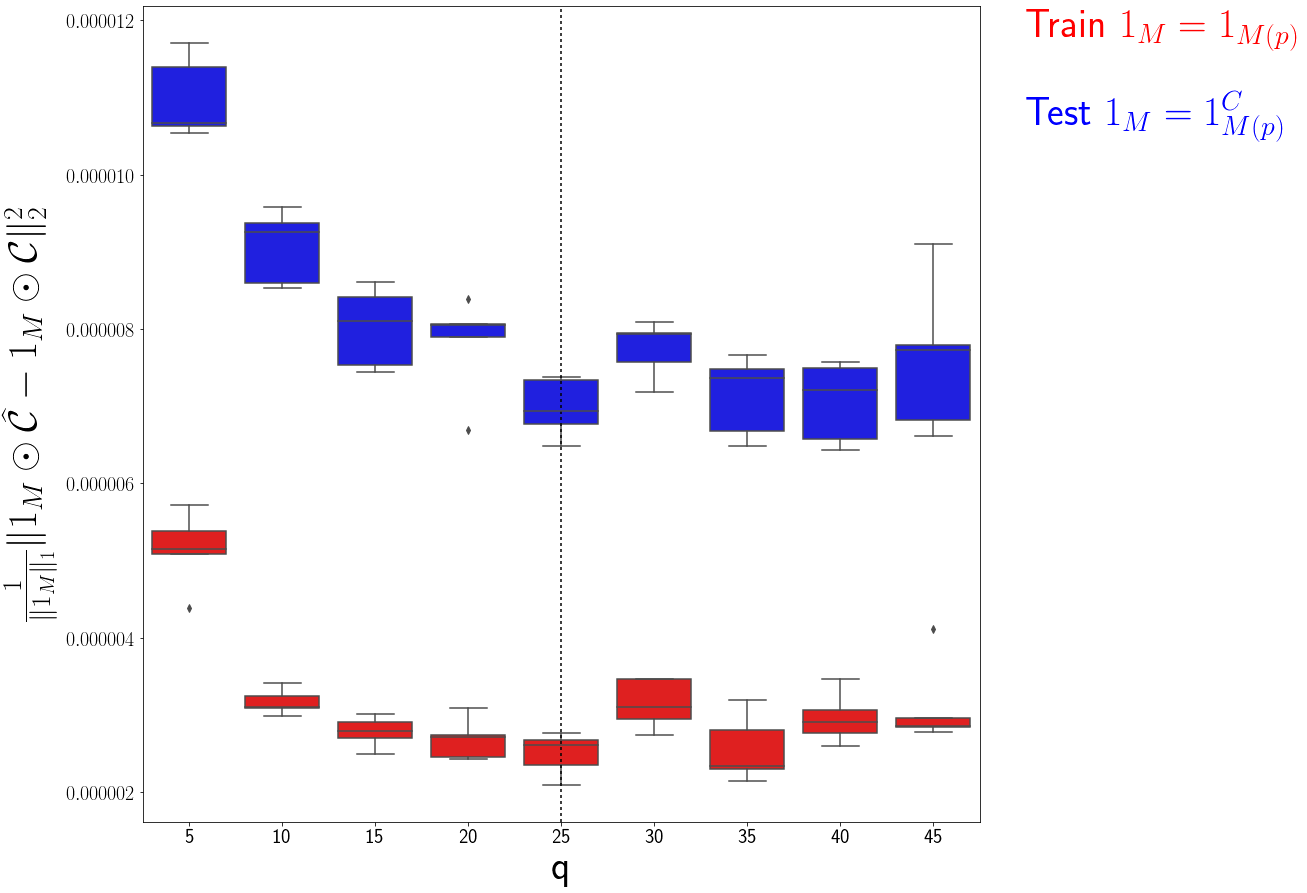

In [44]:
splits = np.asarray(['Train','Test'])
colorsplits = {}
colorsplits['Train'] = 'red'
colorsplits['Test']=  'blue'

fig , ax = plt.subplots(figsize = (15,15))
sns.boxplot( data = te_results[:,1:], ax=  ax, color= 'blue')
sns.boxplot( data = tr_results[:,1:], ax=  ax, color= 'red')
#ax.set_xticklabels(list(range(1,11)))
ax.axvline(4, color='k', dashes=[2,2])
ax.text(9,np.nanmax(te_results[:,1:]), 'Train '+ r"$1_M = 1_{M(p)}$",color = 'red', fontsize = 40)
ax.text(9,.9*np.nanmax(te_results[:,1:]), 'Test '+ r"$1_M = 1_{M(p)}^C$",color = 'blue', fontsize = 40)
ax.set_ylabel(r"$\frac{1}{\|1_{M}\|_1 } \| 1_{M} \odot \widehat {\mathcal C} - 1_{M} \odot \mathcal C \|_2^2$", fontsize = 40)
ax.set_xlabel('q', fontsize = 40)
ax.set_xticklabels(np.asarray(list(range(1,11)))*5, fontsize = 20)
#plt.yticklabels(list(ax.get_yticklabels()), fontsize = 20)
plt.yticks(fontsize = 20)
fig.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/KoelleConnectivity/figs/test_train_0603.png', bbox_inches = 'tight',
   pad_inches = 0)
#ax.legend()

In [335]:
data = np.asarray(fill_df_na(wt_conn, low_values))
rss= np.nansum(data, axis = 1)
ids = np.where(rss > 0.)[0]
data = data[ids]

ncomp = 15
nreps = 10
components = np.zeros((nreps,ncomp,1123))
for r in range(nreps):
    print(r)
    nmf = NMF(n_components=ncomp, alpha=.0002, l1_ratio=1., solver='mu', init = 'random', max_iter=500)
    nmf.fit(data)
    components[r] = nmf.components_

0


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


3
4


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


5


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


6


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


7
8


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


9


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [336]:
combined = rearrange(components, 'r c p -> (r c) p')
nclusts = np.asarray([10,15,20,25,30])
nreps_cluster = 15
np.nanmax(data)

results = np.zeros(nclusts.shape[0])
for d in range(len(nclusts)):
    print(d)
    nclust = nclusts[d]
    cluster_reps = np.zeros((nreps_cluster,combined.shape[0]))
    for c in range(nreps_cluster):
        
        kmeans  = cluster.KMeans(n_clusters=nclust)
        kmeans.fit(combined)
        clusts = kmeans.labels_[kmeans.labels_.argsort()]
        cluster_reps[c] = kmeans.labels_
        
        
        rands = np.zeros((nreps_cluster,nreps_cluster))
        rands[:] = np.nan
    for i in range(nreps_cluster):
        #print(i)
        for j in range(nreps_cluster):
            if i != j:
                rands[i,j] = metrics.adjusted_rand_score(cluster_reps[i], cluster_reps[j])
                    
    results[d] = np.nanmean(rands)
    
results

0
1
2
3
4


array([0.72133463, 0.85565434, 0.87045479, 0.94038781, 0.9236263 ])

In [337]:
rcomb = np.vstack([np.asarray(list(range(1,6)))*5 + 5,results])

In [338]:
stab = pd.DataFrame(rcomb, index = ['q','Rand index']).transpose()

In [339]:
print(stab.transpose().to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &          0 &          1 &          2 &          3 &          4 \\
\midrule
q          &  10.000000 &  15.000000 &  20.000000 &  25.000000 &  30.000000 \\
Rand index &   0.721335 &   0.855654 &   0.870455 &   0.940388 &   0.923626 \\
\bottomrule
\end{tabular}



In [340]:
nclust = 25
kmeans  = cluster.KMeans(n_clusters=nclust)
kmeans.fit(combined)
clusts = kmeans.labels_[kmeans.labels_.argsort()]
cclusts = Counter(clusts)
topclusts  = np.asarray(list(cclusts.keys()))[np.asarray(list(cclusts.values())).argsort()][-15:]
top_clust_inds = np.where(np.isin(clusts, topclusts))[0]

In [341]:
#toplot_log = np.log(toplot)
# lowlim = -6
# toplot[toplot < lowlim] = lowlim

In [342]:
targs = np.asarray(list(wt_conn.columns))[:,1]
layers_targs = np.zeros(targs.shape[0], dtype = object)
for i in range(targs.shape[0]):
    if np.asarray(list(targs))[i][-3:] == '2/3':
        layers_targs[i] = '2/3'
    if np.asarray(list(targs))[i][-1:] == '1':
        layers_targs[i] = '1'
    if np.asarray(list(targs))[i][-1:] == '4':
        layers_targs[i] = '4'
    if np.asarray(list(targs))[i][-1:] == '5':
        layers_targs[i] = '5'    
    if np.asarray(list(targs))[i][-2:] == '6a':
        layers_targs[i] = '6a' 
    if np.asarray(list(targs))[i][-2:] == '6b':
        layers_targs[i] = '6b'

In [343]:
#multiind cre_inds, layers, summary
#n_clust * nreps_cluster
sel_labels = np.zeros(ncomp*nreps, dtype = str)
sel_labels[top_clust_inds] = 'Yes'
sel_labels[np.setdiff1d(list(range(ncomp*nreps)),top_clust_inds)] = 'No'
rep_labels = np.asarray(np.repeat(list(range(10)),15)[kmeans.labels_.argsort()], dtype = str)
clust_labels = np.asarray(clusts, dtype = str)
row_multi_ind = np.vstack([sel_labels,rep_labels,clust_labels])
row_multi_ind = np.asarray(row_multi_ind, dtype = str)
row_multi_ind_tuples = list(zip(*row_multi_ind))
row_multi_ind_tuples = pd.MultiIndex.from_tuples(row_multi_ind_tuples, names=['Top 15 basis','Replicate', 'Cluster'])

sel_labels = row_multi_ind_tuples.get_level_values('Top 15 basis')
sel_pal = sns.color_palette("Pastel1", n_colors = np.unique(sel_labels).shape[0])
sel_lut = dict(zip(map(str, np.unique(sel_labels)), sel_pal))
sel_colors = pd.Series(sel_labels, index=row_multi_ind_tuples).map(sel_lut)

rep_labels = row_multi_ind_tuples.get_level_values("Replicate")
#rep_labels = pd.Index(rep_labels, dtype = object)#pd.I(rep_labels, index=  np.asarray( list(range(150)) ,dtype = object))
rep_pal = sns.color_palette("tab20", n_colors = np.unique(rep_labels).shape[0])
rep_lut = dict(zip(map(str, np.unique(rep_labels)), rep_pal))
rep_colors = pd.Series(rep_labels, index=row_multi_ind_tuples).map(rep_lut)


#clust_labels = pd.DataFrame(clust_labels, index=  np.asarray( list(range(150)) ,dtype = object))
clust_labels = row_multi_ind_tuples.get_level_values("Cluster")
#clust_labels= pd.Index(clust_labels, dtype = object)
clust_pal = sns.color_palette("Paired", np.unique(clust_labels).shape[0]) #sns.cubehelix_palette(summary_labels.unique().size, light=.9, dark=0.1, reverse=False, start=0, rot=-1, hue = 1)#sns.cubehelix_palette(summary_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
clust_lut = dict(zip(map(str, np.unique(clust_labels)), clust_pal))
clust_colors = pd.Series(clust_labels, index=row_multi_ind_tuples).map(clust_lut)

arr = np.zeros((ncomp*nreps,3), dtype = object)
arr[:,0] = sel_colors
arr[:,1] = rep_colors
arr[:,2] = clust_colors
combined_colors = pd.DataFrame(arr, index = clust_colors.index)

toplot = pd.DataFrame(np.log10(combined[kmeans.labels_.argsort()]), index= combined_colors.index)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10


In [344]:
arr_targ = np.zeros((1123,2), dtype = object)
arr_targ[:,0] = hemi_colors
arr_targ[:,1] = targ_str_colors
combined_colors_targ = pd.DataFrame(arr_targ, index = wt_conn.columns)


toplot.columns = combined_colors_targ.index
toplot[toplot < -6] = -6

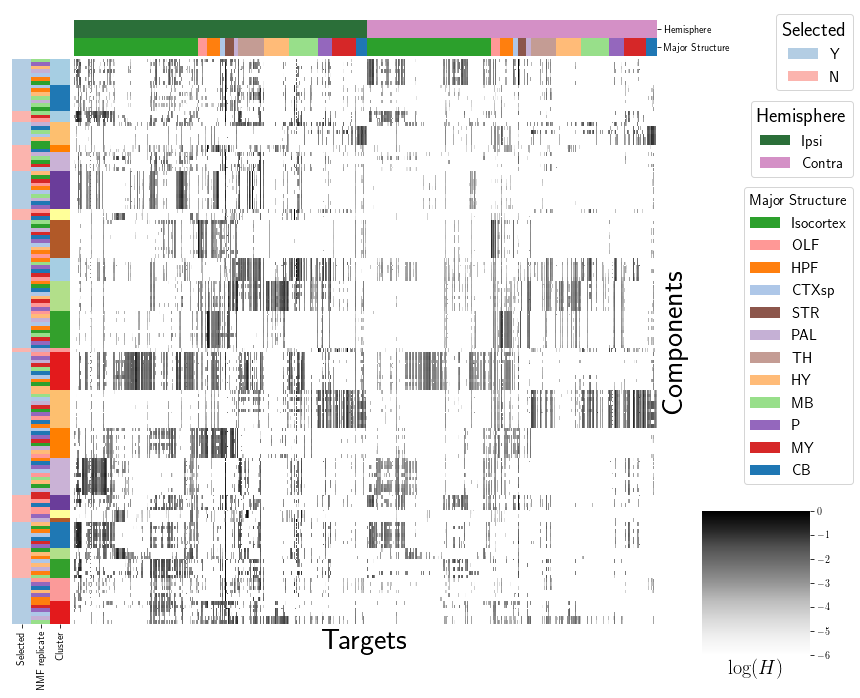

In [345]:
g = sns.clustermap(toplot , 
                   vmin = -6, 
                   vmax= 0, 
                   row_cluster=False,
                   col_cluster=False,
                   row_colors=combined_colors, 
                   col_colors = combined_colors_targ,
                   cbar_pos = [.98,0.1,.15,.2],
                   dendrogram_ratio=0.001,
                  cmap = 'Greys')
g.ax_col_colors.set_yticklabels(['Hemisphere','Major Structure'])
g.ax_row_colors.set_xticklabels(['Selected','NMF replicate','Cluster'])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xlabel('Targets', fontsize = 30)
g.ax_heatmap.set_ylabel('Components', fontsize = 30)
g.ax_cbar.set_xlabel('$\log( H)$', rotation=0, fontsize = 20)

ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=color_str[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.2, .76), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=15)    

ax2 = gcf().add_axes((0.55,.5,0.,0.))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
for label in hemis:
    ax2.bar(0, 0, color=color_hemi[label], label=label, linewidth=0.)
l4 = ax2.legend(title='Hemisphere', ncol=1, bbox_to_anchor=(1.2, .88), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

ax2 = gcf().add_axes((0.56,.5,0.,0.))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
for label in sel_labels.unique():
    ax2.bar(0, 0, color=sel_lut[label], label=label, linewidth=0.)
l4 = ax2.legend(title='Selected', ncol=1, bbox_to_anchor=(1.2, 1.), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    


g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/KoelleConnectivity/figs/nmfcluster_0620.png', bbox_inches = 'tight', pad_inches = 0)

In [346]:
archetypes = np.zeros((ncomp,wt_conn.shape[1]))
for c in range(ncomp):
    archetypes[c] = np.mean(combined[np.where(kmeans.labels_ == topclusts[c])], axis = 0)
    
#lowlim = -6
toplot = np.log(archetypes)#archetypes#np.log(archetypes)
toplot[np.where(toplot< lowlim)] = lowlim
toplot = pd.DataFrame(toplot, columns = wt_conn.columns)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [347]:
wt_conn.columns.names = np.asarray(['Hemisphere', 'Structure'])
hemi_labels = wt_conn.columns.get_level_values("Hemisphere")
hemi_pal = sns.color_palette("cubehelix", n_colors = hemi_labels.unique().size)
hemi_lut = dict(zip(map(str, hemi_labels.unique()), hemi_pal))
hemi_colors = pd.Series(hemi_labels, index=wt_conn.columns).map(hemi_lut)

targ_str_labels = ool_ic_majors#wt_conn.columns.get_level_values("Structure")
targ_str_pal = sns.color_palette("tab20", n_colors = np.unique(targ_str_labels).size)
targ_str_lut = dict(zip(map(str, np.unique(targ_str_labels)), targ_str_pal))
targ_str_colors = pd.Series(targ_str_labels, index=wt_conn.columns).map(targ_str_lut)

layer_labels_col = np.asarray(layers_targs, dtype = str)#col_multi_ind_tuples.get_level_values("Layer")
layer_pal = sns.color_palette("Set1", n_colors = 6) #sns.cubehelix_palette(layer_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
layer_lut_col = dict(zip(map(str, np.unique(np.asarray(layer_labels_col, dtype = str))[1:]), layer_pal))
layer_colors = pd.Series(layer_labels_col, index=wt_conn.columns).map(layer_lut_col)


# arr_targ = np.zeros((1123,3), dtype = object)
# arr_targ[:,0] = hemi_colors
# arr_targ[:,1] = targ_str_colors
# arr_targ[:,2] = layer_colors
# combined_colors_targ = pd.DataFrame(arr_targ, index = wt_conn.columns)

component_labels = np.asarray(list(range(15)), dtype = str)#col_multi_ind_tuples.get_level_values("Layer")
component_pal = sns.color_palette("prism", n_colors = 15) #sns.cubehelix_palette(layer_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
component_lut = dict(zip(map(str, np.unique(np.asarray(component_labels, dtype = str))), component_pal))
component_colors = pd.Series(component_labels, index=list(range(15))).map(component_lut)


In [348]:
alpha = .0002
W, H, n_iter = non_negative_factorization(data, n_components=ncomp, init='custom', solver = 'mu',random_state=0, update_H=False, H=archetypes,l1_ratio  = 1, alpha = alpha, regularization='both')
W_pd = pd.DataFrame(W, index = combined_colors_source.index[ids])
W_pd_log = np.log10(W_pd)
W_pd_log[W_pd_log < -6] = -6

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [349]:
W_pd_log.shape

(122, 15)

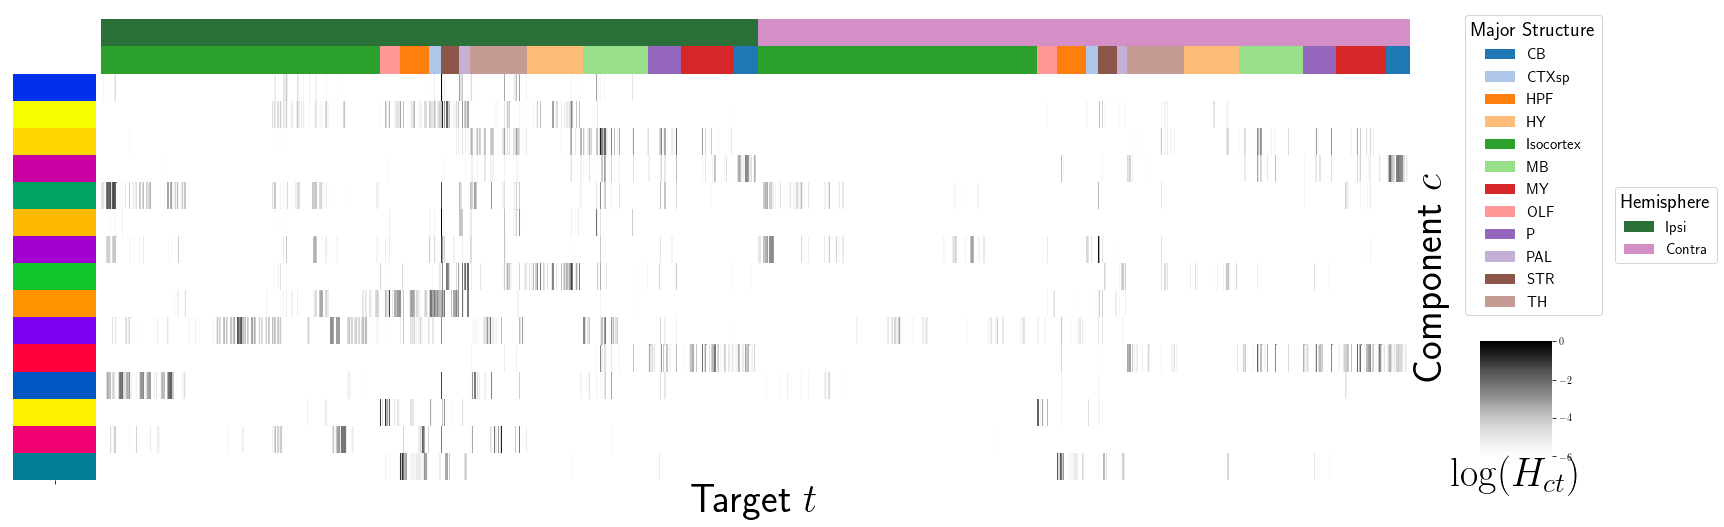

In [350]:
g= sns.clustermap(toplot, 
                  vmin = -6,
                  figsize = (20,8),
                  vmax=  0,
                  col_cluster=False,
                  row_cluster=False,
                  col_colors=combined_colors_targ, 
                  cbar_pos = [1.03,0.22,.05,.2],
                  colors_ratio=0.06,
                  dendrogram_ratio=0.001,
                  row_colors = component_colors,
                 cmap = 'Greys')
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_ylabel('Component ' + r"$c$", fontsize = 40)
g.ax_heatmap.set_xlabel('Target ' + r"$t$", fontsize = 40)
g.ax_heatmap.set_yticks([])
g.ax_col_colors.set_yticks([])
g.ax_cbar.set_xlabel('$\log( H_{ct})$', rotation=0, fontsize = 40)

ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.unique(targ_str_labels):
    ax.bar(0, 0, color=targ_str_lut[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.12, 1.), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

# ax = gcf().add_axes((0.55,.9,0.,0.))
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# #np.unique(np.asarray(layer_labels_col, dtype = str))
# for label in np.unique(layer_labels_col)[1:]:
#     ax.bar(0, 0, color=layer_lut_col[label], label=label, linewidth=0.)
    
# l4 = ax.legend(title='Layers', ncol=1, bbox_to_anchor=(1.2, 1.), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=15)    

ax2 = gcf().add_axes((0.55,.5,0.,0.))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
for label in hemis:
    ax2.bar(0, 0, color=color_hemi[label], label=label, linewidth=0.)
l4 = ax2.legend(title='Hemisphere', ncol=1, bbox_to_anchor=(1.2, .7), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    


g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/figures/H_wt_0617', pad_inches = 0)

In [351]:
#comb_data = pd.concat([wt_conn,Cux2_conn,Ntsr1_conn,Rbp4_conn,Tlx3_conn])
#comb_data = pd.concat([wt_conn,Cux2_conn,Ntsr1_conn,Rbp4_conn,Tlx3_conn])
#gis are structures with nonzero connectivity
#nonzero_leafs  = np.where(np.sum(wt_conn, axis = 1) !=0.)[0]

#get layers (inelegant)
layers= np.zeros(wt_conn.shape[0], dtype = object)
for i in range(wt_conn.shape[0]):
    if np.asarray(list(wt_conn.index))[i][-3:] == '2/3':
        layers[i] = '2/3'
    if np.asarray(list(wt_conn.index))[i][-1:] == '1':
        layers[i] = '1'
    if np.asarray(list(wt_conn.index))[i][-1:] == '4':
        layers[i] = '4'
    if np.asarray(list(wt_conn.index))[i][-1:] == '5':
        layers[i] = '5'    
    if np.asarray(list(wt_conn.index))[i][-2:] == '6a':
        layers[i] = '6a' 
        #print('6a')
    if np.asarray(list(wt_conn.index))[i][-2:] == '6b':
        layers[i] = '6b'
        
layer_labels_row = layers[ids]#col_multi_ind_tuples.get_level_values("Layer")
layer_pal_row = sns.color_palette("Set1", n_colors = 6) #sns.cubehelix_palette(layer_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
layer_lut_row = dict(zip(map(str, np.unique(np.asarray(layer_labels_row, dtype = str))[1:]), layer_pal_row))
layer_colors_row = pd.Series(layer_labels_row, index=wt_conn.index[ids]).map(layer_lut_row)

arr_targ = np.zeros((len(ids),2), dtype = object)
arr_targ[:,0] = source_str_colors[ids]
arr_targ[:,1] = layer_colors_row
#arr_targ[:,2] = layer_colors
combined_colors_source2 = pd.DataFrame(arr_targ, index = wt_conn.index[ids])

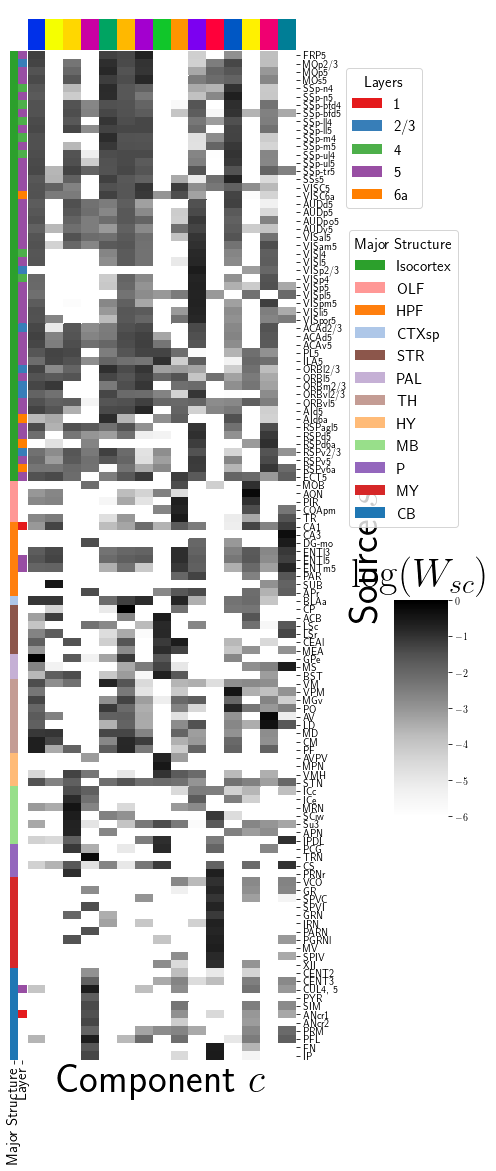

In [361]:
g= sns.clustermap(W_pd_log, vmin = -6, 
                  figsize = (5,15),
                  vmax=  0,
                  col_cluster=False, 
                  row_cluster=False,
                  cmap  = 'Greys',
                  row_colors = combined_colors_source2,
                  col_colors = component_colors,
                  cbar_pos = [1.1,0.25,.15,.2],
                 dendrogram_ratio=0.001)
                  #row_colors=crow[ids])

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('Component ' + r"$c$", fontsize = 40)
g.ax_heatmap.set_ylabel('Source ' + r"$s$", fontsize = 40)
g.ax_heatmap.set_yticks(np.asarray(list(range(W_pd_log.index.shape[0]))) + .5)
g.ax_heatmap.set_yticklabels(W_pd_log.index, fontsize = 10)
g.ax_row_colors.set_xticklabels(['Major Structure','Layer'], fontsize = 15)
g.ax_cbar.set_title(r"$\log(W_{sc})$", rotation=0, fontsize = 40)
#g.ax_col_colors.set_yticklabels(['Component'], fontsize = 15)
g.ax_col_colors.set_yticks([])

ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=color_str[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.3, .8), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=15)    

ax = gcf().add_axes((0.55,.9,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#np.unique(np.asarray(layer_labels_col, dtype = str))
for label in np.unique(layer_labels_col)[1:-1]:
    ax.bar(0, 0, color=layer_lut_row[label], label=label, linewidth=0.)
    
l4 = ax.legend(title='Layers', ncol=1, bbox_to_anchor=(1.2, .95), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=15)    

# l4 = ax.legend(title='Layers', ncol=1, bbox_to_anchor=(1.3, .7), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=15)    
g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/figures/W_wt_0617', pad_inches = 0)

In [353]:
output = np.log10(W@H)
output[np.where(np.isnan(data))] = np.nan
output = pd.DataFrame(output, columns = wt_conn.columns, index = wt_conn.index[ids])

output.columns.names = np.asarray(['Hemisphere', 'Structure'])
hemi_labels = wt_conn.columns.get_level_values("Hemisphere")
hemi_pal = sns.color_palette("cubehelix", n_colors = hemi_labels.unique().size)
hemi_lut = dict(zip(map(str, hemi_labels.unique()), hemi_pal))
hemi_colors = pd.Series(hemi_labels, index=wt_conn.columns).map(hemi_lut)

targ_str_labels = ool_ic_majors#wt_conn.columns.get_level_values("Structure")
targ_str_pal = sns.color_palette("tab20", n_colors = np.unique(targ_str_labels).size)
targ_str_lut = dict(zip(map(str, np.unique(targ_str_labels)), targ_str_pal))
targ_str_colors = pd.Series(targ_str_labels, index=wt_conn.columns).map(targ_str_lut)

source_str_labels = ool_i_majors
source_str_pal = sns.color_palette("tab20", n_colors = np.unique(source_str_labels).size)
source_str_lut = dict(zip(map(str, np.unique(source_str_labels)), source_str_pal))
source_str_colors = pd.Series(source_str_labels, index=wt_conn.index).map(source_str_lut)

arr_targ = np.zeros((1123,2), dtype = object)
arr_targ[:,0] = hemi_colors
arr_targ[:,1] = targ_str_colors
combined_colors_targ = pd.DataFrame(arr_targ, index = wt_conn.columns)

arr_source = np.zeros((564,1), dtype = object)
arr_source[:,0] = source_str_colors
combined_colors_source = pd.DataFrame(arr_source, index = wt_conn.index)


combined_colors_targ.columns = np.asarray(['Hemisphere','Major Structure'])
combined_colors_source.columns = np.asarray(['Major Structure'])

strs_unique = np.unique(ool_ic_majors)
nstr = len(strs_unique)
cs = sns.color_palette("tab20", nstr)

#print(np.asarray(cs).shape, np.expand_dims(np.ones(12),1).shape)
#cs_alphas = np.hstack([np.asarray(cs), alpha*np.expand_dims(np.ones(12),1)])
color_str = {}
for i in range(nstr):
    #print(i)
    color_str[strs_unique[i]] = cs[i]
  
cs_hemi = sns.color_palette("cubehelix", 2)

color_hemi = {}
hemis = np.asarray(['Ipsi','Contra'])
for i in range(2):
    #print(i)
    color_hemi[hemis[i]] = cs_hemi[i]

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


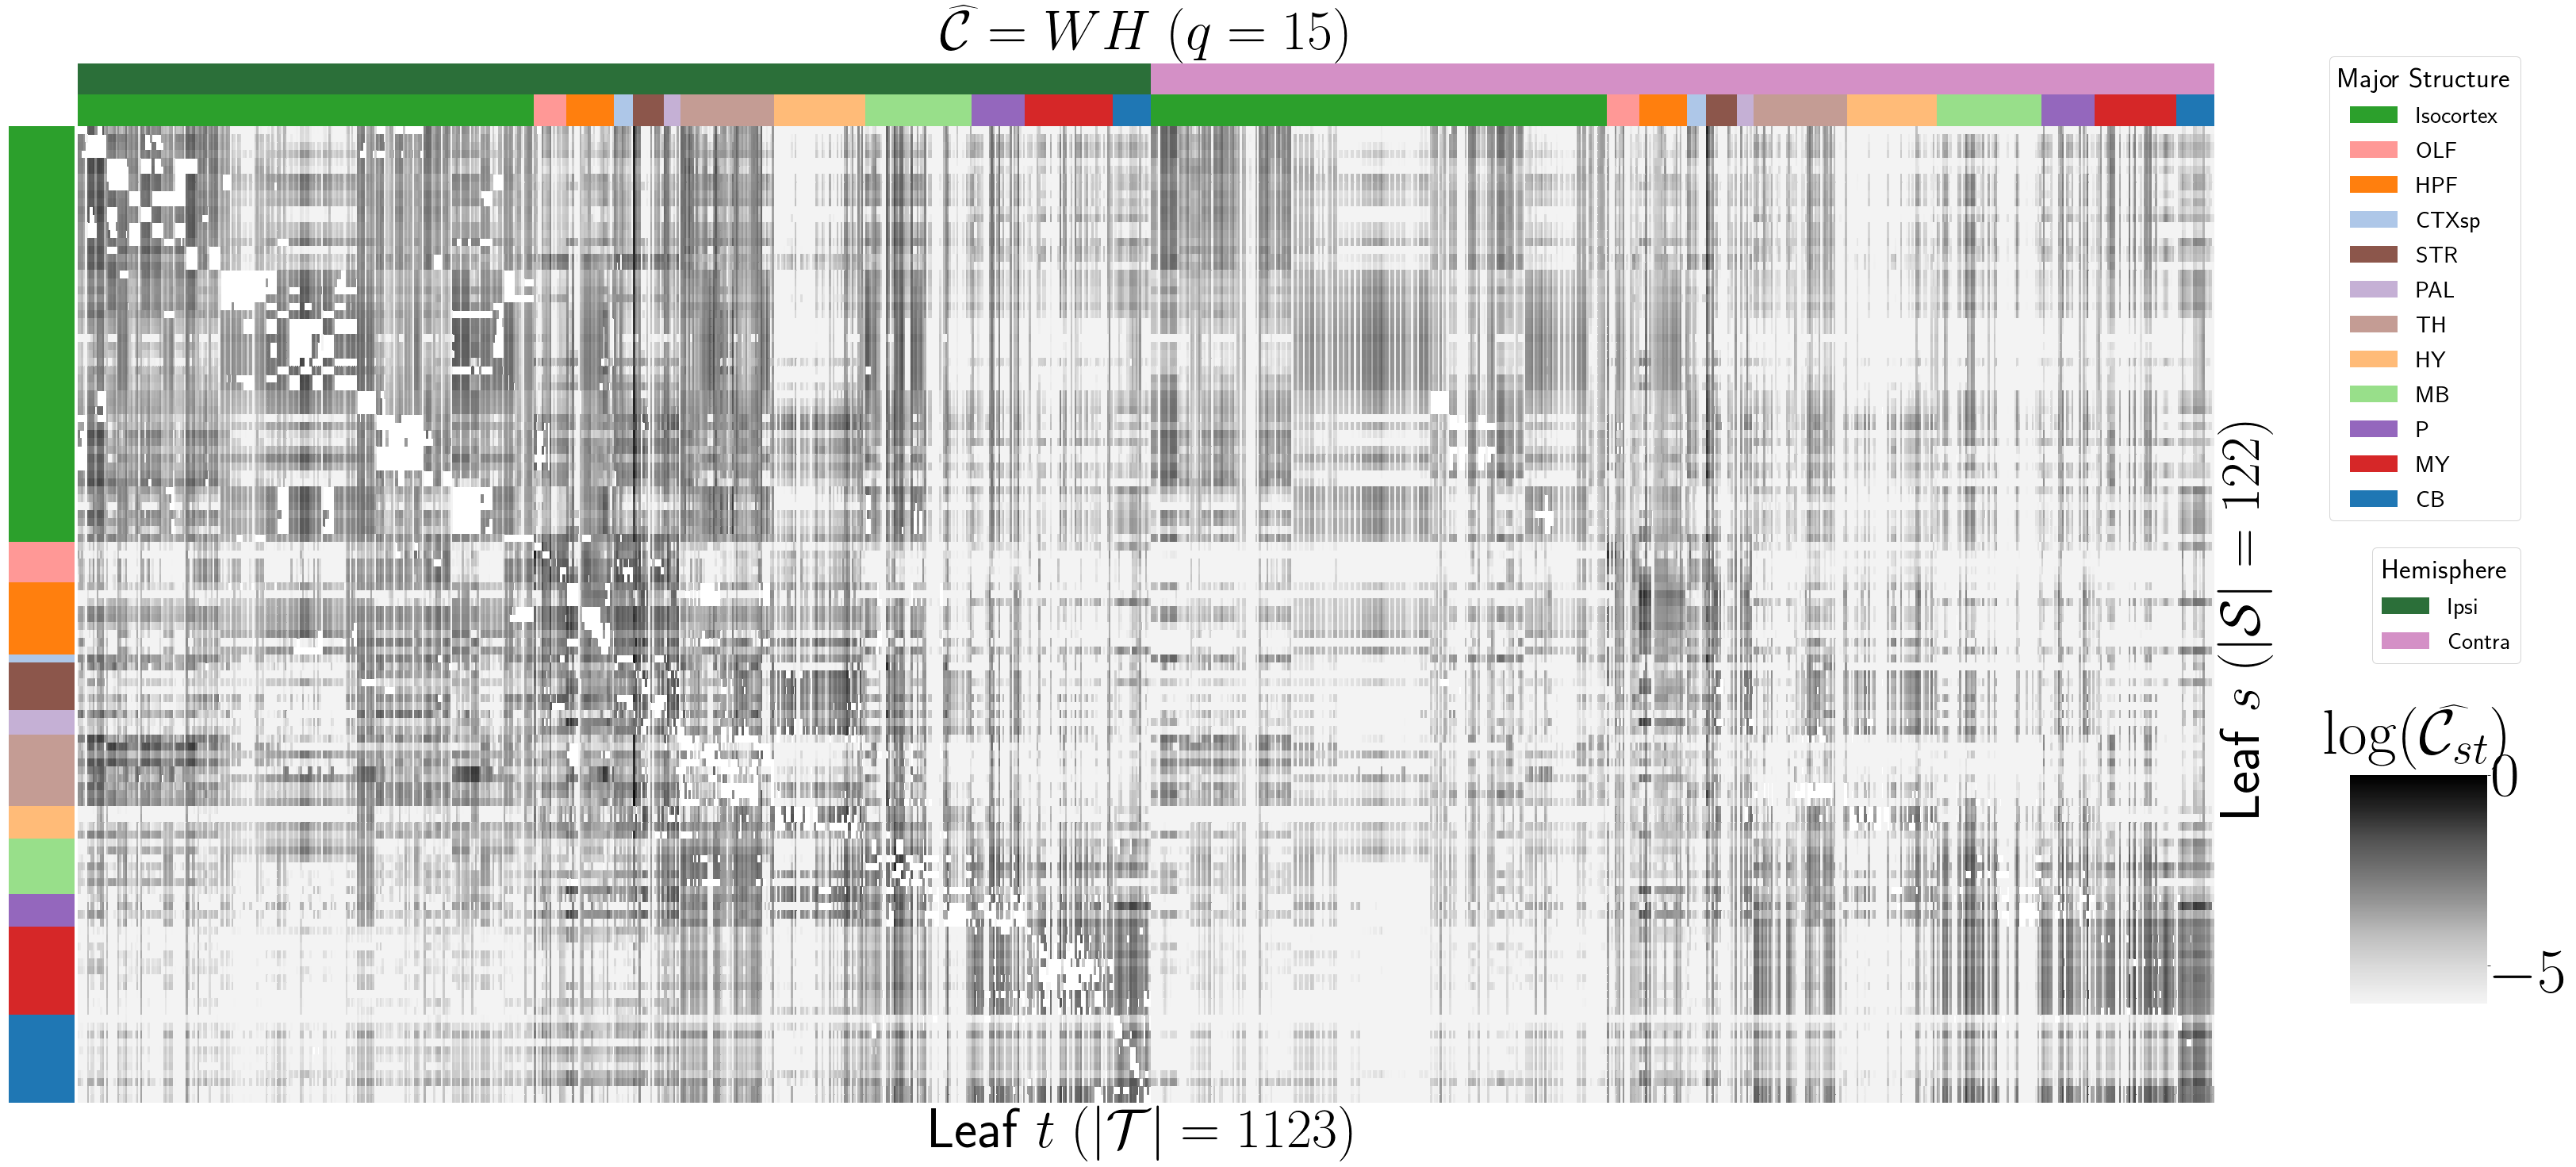

In [354]:
g= sns.clustermap(output, col_cluster = False, row_cluster = False, col_colors=combined_colors_targ, 
                  row_colors = combined_colors_source, figsize = (40,20), cmap = new_cmap, vmin = -6, vmax = 0.,
                 dendrogram_ratio=(0,0.01),cbar_kws={"ticks":[-5,0]}, cbar_pos = [1.03,0.16,.06,.2])
#labels = list(g.ax_cbar.get_yticklabels()).copy()#g.ax_cbar.get_yticklabels()
#print(list(labels))
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
g.ax_col_colors.set_yticks([])
g.ax_row_colors.set_xticks([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])

g.ax_heatmap.set_xlabel('Leaf ' + r"$t \; (|\mathcal T| = 1123)$", fontsize = 70)
g.ax_heatmap.set_ylabel('Leaf ' + r"$s \; (|\mathcal S| = 122)$", fontsize = 70)

ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=color_str[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.11, 1.), bbox_transform=gcf().transFigure, fontsize = 30,title_fontsize=35)    

ax2 = gcf().add_axes((0.55,.5,0.,0.))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
for label in hemis:
    ax2.bar(0, 0, color=color_hemi[label], label=label, linewidth=0.)
l4 = ax2.legend(title='Hemisphere', ncol=1, bbox_to_anchor=(1.11, .57), bbox_transform=gcf().transFigure, fontsize = 30,title_fontsize=35)    
g.ax_cbar.set_title(r"$\log (\widehat{ \mathcal C_{st}})$", rotation=0, fontsize = 80)
g.ax_cbar.set_yticklabels(g.ax_cbar.get_yticklabels(), fontsize=80)
#g.ax_cbar.set_position()

g.ax_col_colors.set_title(r"$\widehat{ \mathcal C} = WH \; ( q = 15)$", fontsize = 70)

plt.margins(x=0,y=0)
g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/figures/conn_leafs_recon_0617.png', bbox_inches = 'tight',pad_inches = 0)

#g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/KoelleConnectivity/wt_conn_sumleaf_strength', pad_inches = 0,bbox_inches = 'tight')